In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import time

import imagepers

from skimage.filters import threshold_otsu, median, threshold_multiotsu
from scipy.signal import peak_widths, find_peaks, peak_prominences
from scipy.ndimage import shift
from scipy.optimize import curve_fit
from scipy import interpolate

# https://www.sthu.org/code/codesnippets/imagepers.html

# !!! подразумевается, что изначальное изображение квадратное

In [ ]:
# fig = plt.figure(figsize=plt.figaspect(0.5))
# ax = fig.add_subplot(1, 2, 1)
# ax.imshow(im)

# %matplotlib notebook
# ax = fig.add_subplot(1, 2, 2, projection='3d')
# xx, yy = np.mgrid[0:im.shape[0], 0:im.shape[1]]
# ax.plot_surface(xx, yy, im, rstride=10, cstride=10)
# plt.show()

In [56]:
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
from scipy.ndimage.filters import maximum_filter


def detect_peaks(image):
    st = time.perf_counter()
    """
    Takes an image and detect the peaks usingthe local maximum filter.
    Returns a boolean mask of the peaks (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """

    # define an 8-connected neighborhood
    neighborhood = generate_binary_structure(2,2)

    #apply the local maximum filter; all pixel of maximal value 
    #in their neighborhood are set to 1
    local_max = maximum_filter(image, footprint=neighborhood)==image
    #local_max is a mask that contains the peaks we are 
    #looking for, but also the background.
    #In order to isolate the peaks we must remove the background from the mask.

    #we create the mask of the background
    background = (image==0)

    #a little technicality: we must erode the background in order to 
    #successfully subtract it form local_max, otherwise a line will 
    #appear along the background border (artifact of the local maximum filter)
    eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)

    #we obtain the final mask, containing only peaks, 
    #by removing the background from the local_max mask (xor operation)
    detected_peaks = local_max ^ eroded_background
    print('detect_peaks time:', time.perf_counter() - st)
    return detected_peaks

In [20]:
def myPEAKS(im, accuracy=None):
    im = im*(255 / np.max(im))
    '''
    Функция для поиска пиков в 2d массиве. Изображение на вход лучше подавать "очищенным"
    
    im - 2d array, изображение
    accuracy - точность разделения пиков
    '''
    st = time.perf_counter()
    g0 = imagepers.persistence(im)
#     print(g0)
    x_coord, y_coord = [], []

    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(20, 5))

    ax.set_title("Peristence diagram")
    ax.plot([0,255], [0,255], c='grey')
    for i, homclass in enumerate(g0):
        p_birth, bl, pers, p_death = homclass
#         print(f'p_birth: {p_birth}, bl (birth lvl): {bl}, pers: {pers}, death lvl: {bl-pers}, p_death: {p_death}')
#         if pers <= accuracy:
#             continue

        x, y = bl, bl-pers
        ax.scatter(x, y, s=5)
        ax.text(x, y+2, str(i+1))
    ax.set_xlabel("Birth level, indicates the maximum distance between adjacent peaks")
    ax.set_ylabel("Death level, indicates the size of the peak")


    ax2.set_title("Loci of births")
    for i, homclass in enumerate(g0):
        p_birth, bl, pers, p_death = homclass
        if pers <= accuracy:
            continue

        y, x = p_birth

        x_coord.append(x)
        y_coord.append(y)
        ax2.scatter(x, y, s=5)
        ax2.imshow(im)
        ax2.text(x, y+1, str(i+1))
    
    converated_peaks = [(y_coord[i] * im.shape[0]) + x_coord[i] for i in range(len(y_coord))] # перевод 2d координат пиков в 1d 
    converated_peaks = np.sort(converated_peaks)
    print('myPEAKS time:', time.perf_counter()-st)
    return [x_coord, y_coord], converated_peaks

def func1(im, accuracy=None):
    '''
    Функция поиска всех пиков на изображении. Возвращает координаты и значения пиков в развернутом 1d изображении.
    
    Если расстояние между соседними пиками в развернутом 1d массиве больше, чем размер изначального изображения,
    то между этими соседними точками добавляются нулевые-точки-значения.
    
    Эта функция полезна для последующей интерполяции, так как она позволяет разделить изначальную группу пиков в 1d массиве
    на несколько взависимости от изначального расстояния между этими пиками
    
    im - 2d изображение;
    accuracy - точность определения границы, при которой добавляются нулевые значения;
    '''
    peak_coord, peak_value = find_peaks(im, height=0)
    peak_value = np.array(list(peak_value.items())[0][1])
    border_value = accuracy
    if np.any(np.where(np.diff(peak_coord) > border_value)[0]):
        border = np.where(np.diff(peak_coord) > border_value)[0][0]
        arr2 = [peak_coord[border] + (i+1)*border_value for i in range(np.diff(peak_coord)[border]//border_value)]
        new_peak_coord = np.concatenate([peak_coord[0:border+1], arr2, peak_coord[border+1:]], axis=0)
        new_peak_value = np.concatenate([peak_value[0:border+1], np.zeros_like((arr2,))[0], peak_value[border+1:]], axis=0)

    else:
        new_peak_coord = peak_coord
        new_peak_value = peak_value
    return new_peak_coord, new_peak_value

def func2(peak_coord, peak_value, kind="linear"):
    '''
    Функция интерполяции по точкам найденных пиков. 
    
    peak_coord - координаты пиков
    peak_value - значения пиков
    kind - тип интерполяции
    '''
    x = np.linspace(peak_coord[0], peak_coord[-1], peak_coord[-1]-peak_coord[0])
    interp = interpolate.interp1d(peak_coord, peak_value, kind=kind) 
    y_nearest = interp(x)
    y2 = np.pad(y_nearest, (peak_coord[0], len(im.ravel())-peak_coord[-1]), 'constant', constant_values=(0))
    return y2

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


def func3(values2, converated_peaks):
    '''
    Функция сопоставления изначальных пиков с пиками, полученными после интерполяции. Так как ширину можно узнать только
    у интерполированного пика (потому что он закреплен на графике), то нужно сопоставить этот пик с реальным,
    чтобы соотнести ширину этого пика с реальным.
    
    values2 - интерполированные пики
    converated_peaks - исходные пики
    '''
    peak_coord, peak_value = find_peaks(values2, height=0)
    peak_value = np.array(list(peak_value.items())[0][1])
    
    prominences = peak_prominences(values2, peak_coord)[0]
    contour_heights = values2[peak_coord] - prominences
    results_half = peak_widths(values2, peak_coord, rel_height=0.5, prominence_data=peak_prominences(values2, peak_coord))
    width=[]
    for i in range(len(converated_peaks)):
        idx = find_nearest(peak_coord, converated_peaks[i])
        width.append(peak_widths(values2, [peak_coord[idx]], rel_height=0.5, 
                                         prominence_data=peak_prominences(values2, [peak_coord[idx]]))[0][0])

    info = [peak_coord, contour_heights, results_half, peak_value]
    return width, info

def myWIDTH(im, true_peaks, draw_output=None):
    '''
    Функция для определения ширины пиков.
    
    im - 2d изображение
    true_peaks - координаты пиков, переведенные в 1d массив
    '''
    st = time.perf_counter()
    peaks, values = func1(im.ravel(), accuracy=im.shape[0]+5)
    if len(peaks) == 1:
        print('!WARNING: only one peak detected, plotting impossible\n')
        width = peak_widths(im.ravel(), [true_peaks][0], rel_height=0.5)[0]
        
    else:
        peaks, values = func1(im.ravel(), accuracy=im.shape[0]+5) # ищем изначальные пики
        values2 = func2(peaks, values) # интерполируем найденные пики
        width, info = func3(values2, true_peaks) # ищем новые пики после интерполяции и далее определяем их ширину
    print('peaks:')
    for i in range(len(true_peaks)):
        print('1d:', true_peaks[i], '|', '2d:', np.unravel_index(true_peaks[i], im.shape), '|', 'width:', width[i])
    print('myWIDTH time:', time.perf_counter()-st)
    #-------------------------------
    if draw_output == 'yes' and len(peaks) != 1:
        plt.figure()
        plt.plot(im.ravel(), c='gray', ls='--', alpha=0.5, label='изначальное 1d изображение')
        plt.plot(values2, c='black', alpha=0.5, label='интерполяция')
        plt.scatter(true_peaks, values2[true_peaks], c='red', marker='x', label='целевые пики')
        plt.scatter(info[0], info[3], c='black', alpha=0.5, marker='o', label='пики после интерполяции')
        results_half = info[2]
        plt.hlines(*results_half[1:], color="C4", label='полуширина')
        plt.vlines(x=info[0], ymin=info[1], ymax=values2[info[0]], color='C2', label='высота')
        plt.legend(loc='upper left', fontsize='xx-small', bbox_to_anchor=(1.05, 1.0))
        plt.xlim(peaks[0]-2000, peaks[-1]+2000)
        plt.show()
    
    return np.unravel_index(true_peaks, im.shape), width

def best_thresh(img, acc=None):
    '''
    Функция для нахождения наилучшего значения threshold с помощью разных конфигураций алгоритма Оцу
    
    img - 2d изображение
    acc - макисмалньый процент полезного сигнала от всего изображения (по дефолту = 5)
    '''
    img_size = img.shape[0]*img.shape[1]
    one_percent = img_size/100
    final_thresh = []
    for i in range(2, 5, 1):
        for j in range(len(threshold_multiotsu(img, classes=i))):
            thresh = threshold_multiotsu(img, classes=i)[j]
            found_values_size = len(np.where(img * (img > thresh) != 0)[1])
            found_percent = found_values_size/one_percent
            if thresh>0 and found_percent<acc:
                final_thresh.append(thresh)
    final_thresh = np.min(final_thresh)    
    return final_thresh

In [ ]:
img = np.loadtxt("D:/astro/domecam/data/20210130l_m2km_corr_4.gz")

D=2.5  # pupil diametr
spf=0.01  # sec per frame
latency=4  # cross corr latency
delta = D/(img.shape[0]//2)
t = spf * latency

a1 = np.loadtxt(f'D:/astro/domecam/z.gz') # распределение гамм по высотам
a2 = np.loadtxt(f'D:/astro/domecam/z_width.gz') # ширина гамм, соответствующая распределениям по высотам
# для того чтобы найти приближенное значение по высоте, нужно индекс ширины из a2 подставить в a1

cjk = np.loadtxt(f'D:/astro/domecam/cjk.gz')
gammas = np.load("D:/astro/domecam/gammas_orig.npy")

im = img.copy()
im = im*(im > threshold_multiotsu(im, classes=3)[0])
im = median(im)
im = im*(255 / np.max(im))
coords2d, coords1d = myPEAKS(im, accuracy=20)
coords2d, widths = myWIDTH(im, coords1d, draw_output='yes')

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

print(' ')
total_Cn2=[]
initial_params=[]
for i in range(len(widths)):
    Vy = (img.shape[0]//2-coords2d[0][i])*delta/t
    Vx = -(img.shape[1]//2-coords2d[1][i])*delta/t
    idx = find_nearest(a2, widths[i])
    Cn2 = (img[coords2d[0][i], coords2d[1][i]] \
           / (cjk[coords2d[0][i], coords2d[1][i]] * np.max(gammas[idx])))
    
    total_Cn2.append(Cn2)
    layer = [Vx, Vy, Cn2, a1[idx]/1000]
    initial_params.append(layer)
    print(f'Vx: {Vx:.2f}, Vy: {Vy:.2f}, Cn2: {Cn2:.2f}*1e-13, z: {a1[idx]/1000:.2f}')
    

r0 = pow(0.423 * pow((2*np.pi/(500*10e-9)), 2) * (np.sum(total_Cn2)*1e-13), -3/5)
seeing = 206265 * 0.98 * 500*10e-9/r0

print('\ntotal Cn2:', np.sum(total_Cn2)*1e-13)
print(f'r0: {r0:.2f}')
print(f'seeing: {seeing:.2f}')

detect_peaks time: 0.003863999999794032
[220 225 230 238] [233 225 213 198]
myPEAKS time: 2.111430500000097
time: 2.4151009000001977


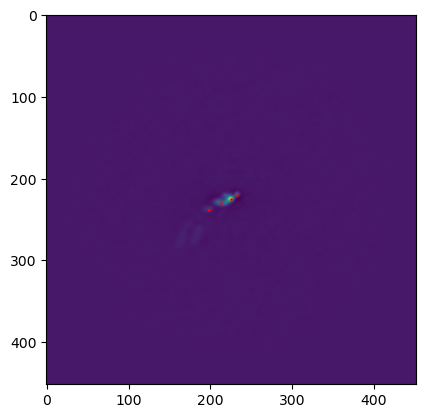

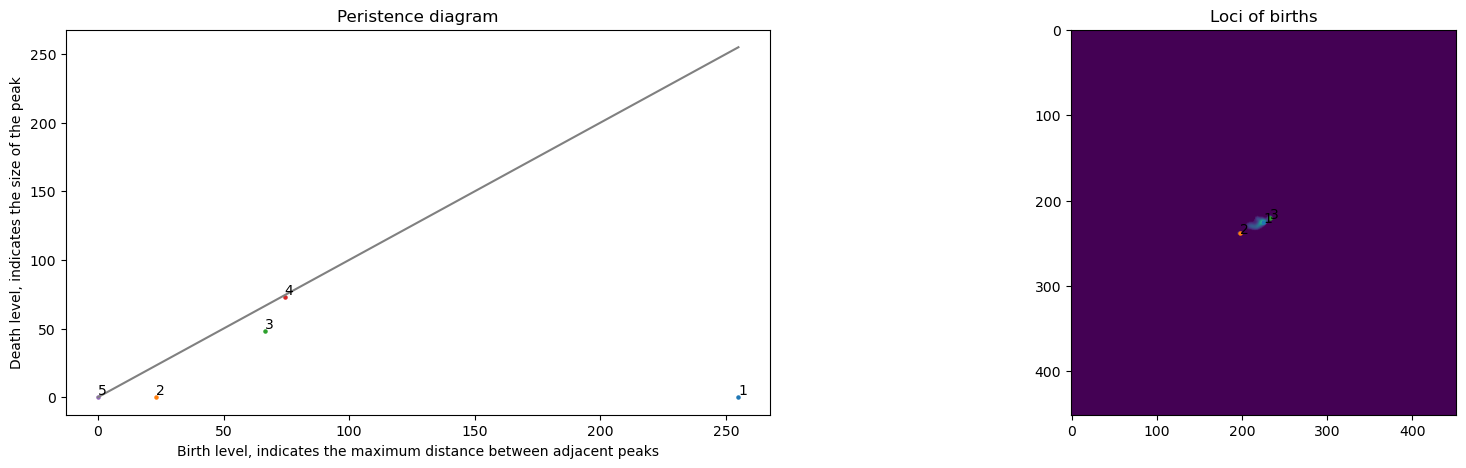

In [60]:
img = np.loadtxt("D:/astro/domecam/data/20210130c_m2km_corr_4_blur.gz")

st = time.perf_counter()

thresh = best_thresh(img, acc=5)
im = img * (img>thresh)

y, x =np.where(detect_peaks(im) != 0)
print(y, x)
plt.figure()
plt.scatter(x, y, c='red', s=1)
plt.imshow(img)

coords2d, coords1d = myPEAKS(im, accuracy=15)

print('time:', time.perf_counter()-st)